### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import *
from sklearn.utils.extmath import svd_flip

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import sklearn.datasets, sklearn.decomposition
from sklearn.decomposition import PCA as sklearnPCA

%matplotlib inline

### Functions

In [2]:
def to_rgb(triplet):

    red = triplet[0]
    green = triplet[1]
    blue = triplet[2]

    return [green, blue, red]

def plot_PCA(Y_pca,Y,vr,b,a):
    
    fig, ax1 = plt.subplots(figsize=[8,8])
    ax1.scatter(Y_pca[:,0], Y_pca[:,1], c=list(map(to_rgb, Y)),s=25,marker="s",alpha=0.4,edgecolor=None)
    ax1.set_xlim([-a,a])
    ax1.set_ylim([-b,b])
    plt.xlabel('PC1 ({0:.1f}%)'.format(vr[0]),fontsize=20)
    plt.ylabel('PC2 ({0:.1f}%)'.format(vr[1]),fontsize=20)
    plt.grid()
    plt.show()

# Principal Component Analysis

## Preprocessing the data

In [3]:
def preprocess_data(reduce=True, scaler=False):

    df0 = pd.read_csv("all_copy.csv", sep=";")
    X0 = df0.iloc[:,17:23].values
    Y0 = df0.iloc[:,2:5].values
    
    if reduce == True:
        X = np.concatenate((X0[:792],X0[891:]))
        Y = np.concatenate((Y0[:792],Y0[891:]))

        if scaler != False:
            X_std = scaler.fit_transform(X)
            return X_std,Y
        else:
            return X,Y
    
    if reduce == False:
        
        if scaler != False:
            X_std = scaler.fit_transform(X0)
            return X_std,Y0
        else:
            return X0,Y0

## Sklearn PCA

Explained variance ratio: [38.2  21.01 16.2  13.85 10.63  0.11]


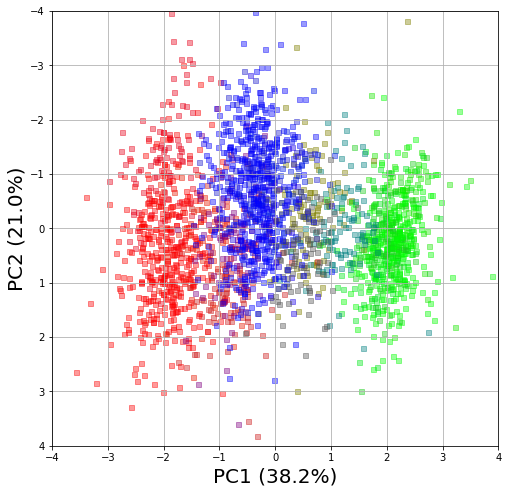

In [4]:
X_std1,Y1 = preprocess_data(reduce=True, scaler=StandardScaler())

pca = sklearnPCA(n_components=6)
Y_sklearn = pca.fit_transform(X_std1)

vr1=np.round(pca.explained_variance_ratio_*100,2)
print("Explained variance ratio:",vr1)

plot_PCA(Y_sklearn,Y1,vr1,-4,4)

## PCA "by hand"
$\begin{aligned}
\begin{align}
&S = \frac{1}{N-1} X^{T}X = V E V^{T}\\
&Y = X \cdot E
\end{align}
\end{aligned}$

Explained variance ratio: [38.2  21.01 16.2  13.85 10.63  0.11]


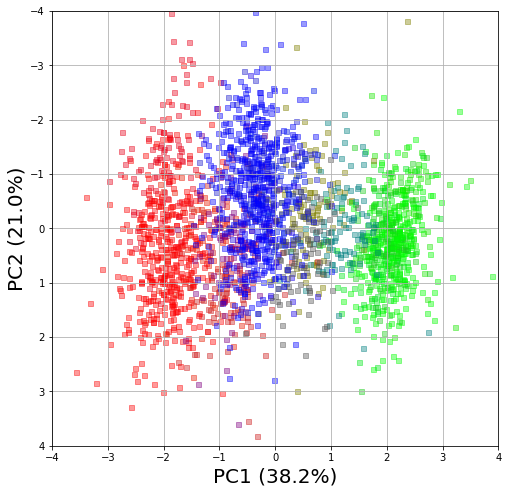

In [5]:
X_std,Y = preprocess_data(True, StandardScaler())

cov_mat = np.cov(X_std.T)


eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort()
eig_pairs.reverse()

E = np.hstack((eig_pairs[0][1].reshape(6,1), 
                      eig_pairs[1][1].reshape(6,1),
                      eig_pairs[2][1].reshape(6,1),
                      eig_pairs[3][1].reshape(6,1),
                      eig_pairs[4][1].reshape(6,1),
                      eig_pairs[5][1].reshape(6,1)))*(-1)

eigenvalues = np.flip(np.sort(eig_vals))

tot = sum(eigenvalues)
vr2 = np.round([(i / tot)*100 for i in sorted(eigenvalues, reverse=True)],2)
print("Explained variance ratio:",vr2)

Y_transform=np.dot(X_std,E)

plot_PCA(Y_transform,Y,vr2,-4,4)

## Singular Value Decomposition (SVD)
$\begin{aligned}
\begin{equation}
X=U D V^{T}
\end{equation}
\end{aligned}$

Sources:

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

https://intoli.com/blog/pca-and-svd/


\begin{equation}
X = \sum_{i=1}^{r}u_{i} d_{i} v_{j}^{T}
\end{equation}

where $\{u_{i}\}$ and $\{v_{i}\}$ are orthonormal sets of vectors, and $r=\text{rank}(X)$.

A comparison with the eigenvalue decomposition of covariance matrix S reveals that the "right singular vectors" $v_{j}$ are equal to the PCs, the "right singular vectors" $u_{i}$ are:

\begin{equation}
u_{i}=\frac{1}{\sqrt{(n-1)e_{i}}}X v_{i}
\end{equation}

and the "singular values" $d_{i}$ are related to the data matrix via

\begin{equation}
d_{i}=\sqrt{(n-1)e_{i}}
\end{equation}

Principal scores are:

\begin{equation}
UD = X V
\end{equation}

In [6]:
X_std,Y = preprocess_data(True, StandardScaler())
N = X_std.shape[0]

u, d, vt = np.linalg.svd(X_std,full_matrices=False)
U, Vt = svd_flip(u, vt)
D = np.zeros((U.shape[1], Vt.shape[0]))
D[:d.size, :d.size] = np.diag(d)
V=Vt.T

#print("U\n",U)
#print("D\n",D)
#print("V\n",V)

Remarks:

Note how some signs are flipped between SVD and PCA. SVD suffers from a problem called “sign indeterminancy”. To work around this, sklearn uses the function svd_flip to insure the results also fit the eigen decomposition. [ [Source](https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative/46183256#46183256) ]

### Examples

1. SVD eigenvectors are equivalent to sklearn eigenvectors, and that SVD PC scores are equivalent to sklearn results:

In [7]:
Y_svd = np.dot(U,D)

print("SVD right singular vectors equal to eigenvectors of the covariance matrix? ",
      np.allclose(V.T,pca.components_))

print("Is final transformed dataset equal? ",
      np.allclose(Y_sklearn,Y_svd))

try:
    np.testing.assert_almost_equal(Y_sklearn,Y_svd)
except AssertionError as err:
    print(err)

SVD right singular vectors equal to eigenvectors of the covariance matrix?  True
Is final transformed dataset equal?  True


2. Singular values $d_{i}$ are related to eigenvalues as:

\begin{equation}
D=\sqrt{(N-1)E}
\end{equation}

In [8]:
E = np.diag(pca.explained_variance_)

D_ = np.sqrt((N-1)*E)
#print(D_)

2. Standardized scores are given as:
\begin{equation}
\sqrt{(N-1)} \cdot U =XV(\sqrt{E})^{-1}
\end{equation}

In [9]:
print(np.allclose(np.sqrt(N-1)*U,np.linalg.multi_dot([X_std,V,np.linalg.inv(np.sqrt(E))])))

True


## Loadings
"Loadings" in PCA are principal axes scaled by the square roots of the respective eigenvalues.
All sources used for loadings:

https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

https://stats.stackexchange.com/questions/104306/what-is-the-difference-between-loadings-and-correlation-loadings-in-pca-and/104640#104640

https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

https://stats.stackexchange.com/questions/291516/factor-loadings-eigenvectors-in-r-output

$\begin{aligned}
\begin{align}
&L_{1} = V\frac{D}{\sqrt{N-1}}\\
&L_{2} = V\sqrt{E}\\
&L_{3}=Cov(X,Y)=\frac{X^{T}Y}{N-1}=\frac{X^{T}(\sqrt{N-1}U)}{N-1}=\frac{DVU^{T}U}{\sqrt{N-1}}= V\sqrt{E}\\
&L_{4} \rightarrow \text{sklearn variant}
\end{align}
\end{aligned}$

In [10]:
l1 = np.dot(V,np.diag(d))/np.sqrt(N-1)
l2 = V*np.sqrt(eigenvalues)
l3 = pca.components_.T*np.sqrt(pca.explained_variance_)
Y_std = StandardScaler().fit_transform(Y_sklearn)
l4 = np.dot(X_std.T,Y_std)/(N-1)

print("Are they all close?:",np.allclose(l1,l2,abs(l3),abs(l4)),"\n")
print("Loadings calculated through sklearn values:\n",np.round(l4,2))

Are they all close?: True 

Loadings calculated through sklearn values:
 [[ 0.09 -0.38  0.9   0.2   0.07  0.  ]
 [-0.39 -0.55 -0.03 -0.66  0.33  0.  ]
 [ 0.53 -0.39 -0.33  0.45  0.51 -0.  ]
 [ 0.17 -0.81 -0.23  0.08 -0.51  0.  ]
 [ 0.95  0.09  0.06 -0.27 -0.03  0.06]
 [ 0.95  0.08  0.06 -0.28 -0.03 -0.06]]


# Appendix

### Variance of Loadings matrix

Vertical sums of squares of loading values are the eigenvalues, components' variances. [ [Source](https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another) ]

In [11]:
L = l3

arr=[]
for i in range(len(L[0])):
    sums=0
    for j in L[:,i]:
        sums=sums+j**2
    arr.append(sums)
    
#print(np.round(arr,3))
#print(np.round(pca.explained_variance_,3))
print("Is the sum of squares of loadings equal to eigenvalues? ",np.allclose(arr,pca.explained_variance_))

Is the sum of squares of loadings equal to eigenvalues?  True


### Correlation matrix

Eigendecomposition of correlation matrix $R$ equals [ [source](https://stats.stackexchange.com/questions/125684/how-does-fundamental-theorem-of-factor-analysis-apply-to-pca-or-how-are-pca-l) ]:

$\begin{aligned}
\begin{align}
&R = VEV^{T}\\
&L = V \sqrt{E}\\
&R = L L^{T}\\
\end{align}
\end{aligned}$

In [12]:
c1 = np.round(np.dot(L,L.T),2)
c2 = np.round(np.corrcoef(X_std.T),2)

#print(c1)
#print(c2)
print("Is dot product of loadings equal to correlation matrix? ",np.allclose(c1,c2))

Is dot product of loadings equal to correlation matrix?  True


### Variance of PC components

Sometimes loadings is a term used for coefficients of principal components that are equal to eigenvectors. Loadings defined that way are not correlations between PC's and original variables because variance of each PC equals corresponding eigenvalue.
PC's are standardized by scaling them with a square root of eigenvalue, which makes the variance of PC scores equal to 1 and allows correlation interpretation of loadings. The term used for such loadings is sometimes standardized loadings.

In [13]:
PCs_std=np.sqrt(N-1)*U

print("Eigenvalues from PCA:\n",np.round(pca.explained_variance_,2),"\n")

def calculate_column_variance(A):
    var=[]
    for i in range(len(A[0])):
        var.append(np.var(A[:,i]))
    return var

var1 = calculate_column_variance(Y_svd)
print("Column variance of Y obtained from SVD\n",np.round(var1,2),"\n")

var2 = calculate_column_variance(PCs_std)
print("Column variance of Standardized PCs - dot product UD\n",np.round(var2,2),"\n")

var3 = calculate_column_variance(Y_std)
print("Column variance of manually standardized Y\n",np.round(var3,2))

Eigenvalues from PCA:
 [2.29 1.26 0.97 0.83 0.64 0.01] 

Column variance of Y obtained from SVD
 [2.29 1.26 0.97 0.83 0.64 0.01] 

Column variance of Standardized PCs - dot product UD
 [1. 1. 1. 1. 1. 1.] 

Column variance of manually standardized Y
 [1. 1. 1. 1. 1. 1.]


### Covariance of standardized variables is equal to correlation matrix.

In [14]:
X,Y = preprocess_data(True, False)
X_std1,Y = preprocess_data(True, StandardScaler())

N=X.shape[0]

covariance = np.cov(X.T)

mean_vec = np.mean(X, axis=0)
cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (N-1)

cov_std = np.cov(X_std.T,ddof=0)
corr = np.corrcoef(X.T)
print("Are all these matrices equal? ",np.allclose(covariance,cov_mat,corr))

Are all these matrices equal?  True
